In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import cartopy.crs as ccrs
import csv
from dataclasses import asdict
from datetime import datetime, timedelta
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal, mindelo, find_ec_lon, vertical_preview, to_kml
import pandas as pd
from orcestra.flight_performance import aircraft_performance

In [111]:
# Define dates for forecast initialization and flight

issued_time = datetime(2024, 8, 24, 0, 0, 0)

flight_time = datetime(2024, 8, 25, 12, 0, 0)
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

print(
    f"Initalization date of IFS forecast: {issued_time}\n"
    f"Flight date: {flight_time:%Y-%m-%d}\n"
    f"Flight index: {flight_index}"
)

Initalization date of IFS forecast: 2024-08-24 00:00:00
Flight date: 2024-08-25
Flight index: HALO-20240825a


In [112]:
# Domain definition
# TO DO: replace by global definition once it exists
lon_min, lon_max, lat_min, lat_max = -65, -5, -10, 25

In [113]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(datetime = issued_time).to_dask().pipe(egh.attach_coords)

In [114]:
# Load ec satellite track for 
ec_track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-24", kind="PRE").get_track_for_day(f"{flight_time:%Y-%m-%d}")
ec_track = ec_track.sel(time=slice(f"{flight_time:%Y-%m-%d} 06:00", None))
ec_lons, ec_lats = ec_track.lon.values, ec_track.lat.values

In [115]:
def ec_time_at_lat(ec_track, lat):
    e = np.datetime64("2024-08-01")
    s = np.timedelta64(1, "ns")
    return (((ec_track.swap_dims({"time":"lat"}).time - e) / s).interp(lat=lat) * s + e)

**Waypoint definitions**

In [116]:
# Mass flux circle radius (m)
halo_radius = 130e3
atr_radius = 70e3

# Setting region (Cabo Verde vs. Barbados)
airport = sal #bco

# Latitudes where we enter and leave the ec track (visually estimated)
lat_ec_north_out = 16.0
lat_ec_north_in = 12.0
lat_ec_south = 2.5

# ITCZ edges visually estimated from iwv contours
lat_c_south = 4.0
lat_c_north = 10.0

# Extra Points along the flight track
lat_c_south_alt_s = 3.25
lat_c_south_alt_n = 4.75

lat_c_north_alt_s = 9.25
lat_c_north_alt_n = 10.75

# Extra Points off the flight track
lat_ec_south_alt = 2.0

In [117]:
# Setting lat/lon coordinates

# Points where we get on ec track
north_ec_in = LatLon(lat_ec_north_in, find_ec_lon(lat_ec_north_in, ec_lons, ec_lats), label = "north_ec_in")
north_ec_out = LatLon(lat_ec_north_out, find_ec_lon(lat_ec_north_out, ec_lons, ec_lats), label = "north_ec_out")
south_ec = LatLon(lat_ec_south, find_ec_lon(lat_ec_south, ec_lons, ec_lats), label = "south_ec")

# Intersection of ITCZ edges with ec track
c_north = LatLon(lat_c_north, find_ec_lon(lat_c_north, ec_lons, ec_lats), label = "c_north")
c_south = LatLon(lat_c_south, find_ec_lon(lat_c_south, ec_lons, ec_lats), label = "c_south")

# Center of middle circle
c_mid = c_south.towards(c_north).assign(label = "c_mid")

# EarthCARE underpass
ec_under = c_north.towards(north_ec_out)
ec_under = LatLon(ec_under.lat, find_ec_lon(ec_under.lat, ec_lons, ec_lats), label = "ec_under")

# ATR circle
atr_circ_sar = LatLon(lat=15.5, lon=-22.1, label="atr_sar")

# Extra Points along the way
c_south_alt_s = LatLon(lat_c_south_alt_s, find_ec_lon(lat_c_south_alt_s, ec_lons, ec_lats), label = "c_south_alt_s")
c_south_alt_n = LatLon(lat_c_south_alt_n, find_ec_lon(lat_c_south_alt_n, ec_lons, ec_lats), label = "c_south_alt_n")

c_north_alt_s = LatLon(lat_c_north_alt_s, find_ec_lon(lat_c_north_alt_s, ec_lons, ec_lats), label = "c_north_alt_s")
c_north_alt_n = LatLon(lat_c_north_alt_n, find_ec_lon(lat_c_north_alt_n, ec_lons, ec_lats), label = "c_north_alt_n")

# Extra Points 
ec_south_alt = LatLon(lat_ec_south_alt, find_ec_lon(lat_ec_south_alt, ec_lons, ec_lats), label = "south_ec_alt")

# Define flight track, can be split into different legs
take_off_time = '2024-08-25T09:15:00Z'
waypoints = [
     airport.assign(time=take_off_time), 
     north_ec_in.assign(fl=400),
     c_north.assign(fl=400),
     c_mid.assign(fl=400),
     c_south.assign(fl=400),
     south_ec.assign(fl=430),
     c_south_alt_s.assign(fl=430),
     IntoCircle(c_south.assign(fl=430), radius, 360),  
     c_south_alt_n.assign(fl=430),
     IntoCircle(c_mid.assign(fl=430), radius, 360), 
     c_north_alt_s.assign(fl=430),
     IntoCircle(c_north.assign(fl=450), radius, 360),
     c_north_alt_n.assign(fl=450),
     ec_under.assign(fl=450),
     north_ec_out.assign(fl=450),
     mindelo.assign(fl=450),
     IntoCircle(atr_circ_sar.assign(fl=350), atr_radius, 360),
     airport
] 

path = fp.expand_path(waypoints, dx=10e3)

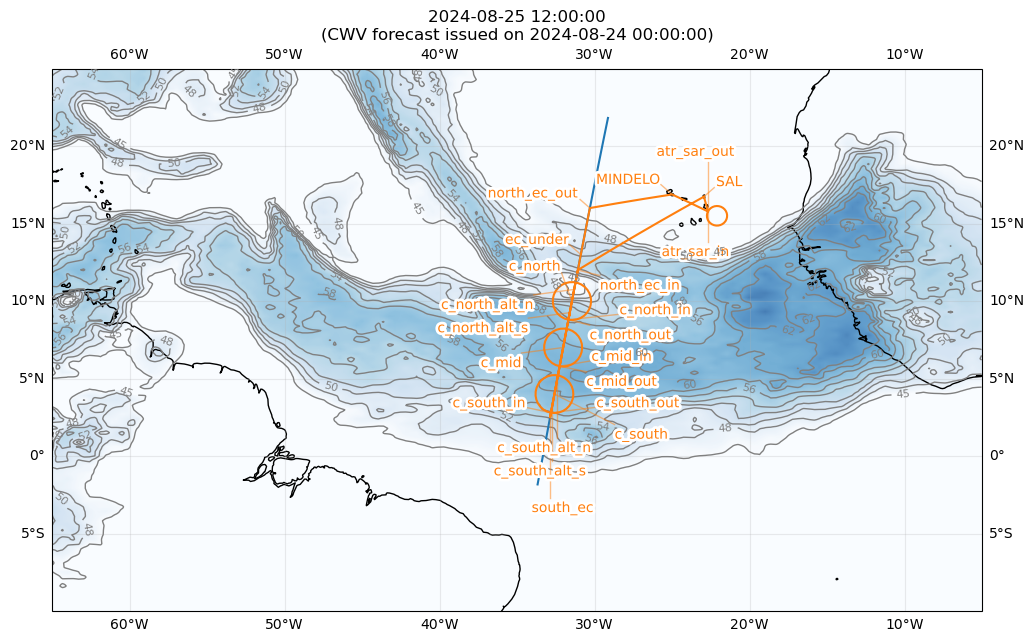

In [118]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [45.0, 48.0, 50.0, 52.0, 54.0, 56.0, 58.0, 60.0, 62.0])
plt.title(f"{flight_time}\n(CWV forecast issued on {issued_time})")

plt.plot(ec_lons, ec_lats)
fp.plot_path(path, ax, color="C1")

In [120]:
crew = {'Mission PI': 'Julia Windmiller',
        'DropSondes': 'Theresa Mieslinger',
        'HAMP': 'Jakob Deutloff',
        'SMART/VELOX': 'Kevin Wolf',
        'SpecMACS': 'Lea Volkmer',
        'WALES' : 'Tanja Bodenbach',
        'Flight Documentation': 'Suelly Katiza',
        'Ground Support': 'Nicola Rochetin',
        }

Text(0.5, 0, 'Distance / m')

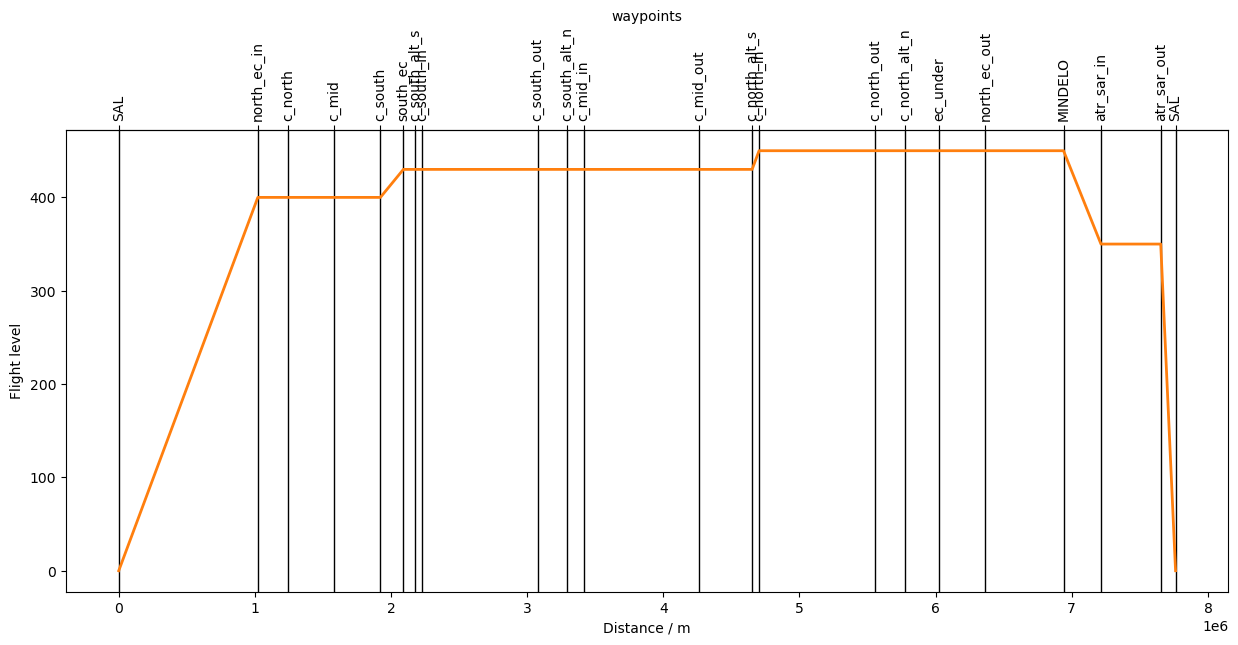

In [121]:
vertical_preview(waypoints)
plt.ylabel("Flight level")
plt.xlabel("Distance / m")

In [124]:
notes = {'c_south_in':'enter from south, CW',
         'c_mid_in':'enter from south, CW',
         'c_north_in':'enter from south, CW',
         'c_atr_in':'enter from west, CW',
         'ec_under':f'overpass at {str(ec_time_at_lat(ec_track, ec_under.lat).values)[:-10]}Z',
         }

In [128]:
# Detailed overview with notes
for index, row in plan.iterrows():
    if (index[0]+index[-4:]!='c_out'):
        print(f"{index:12s} {LatLon(row['lat'],row['lon']).format_pilot():20s}, FL{int(row['fl']):03d}, {row['time']:%H:%M:%S}, {notes.get(index,'')}" )
print ('\n-- circle centers:')
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
        print (f'{point.label:12s} {point.format_pilot()}')
print ('\n-- extra waypoints:')
for point in extra_waypoints:
    print (f'{point.label:12s} {point.format_pilot()}, {notes.get(point.label,'')}' )

SAL          N16 44.07, W022 56.64, FL000, 09:15:00, 
north_ec_in  N12 00.00, W031 04.72, FL400, 10:42:09, 
c_north      N10 00.00, W031 27.63, FL400, 10:58:14, 
c_mid        N07 00.03, W032 01.71, FL400, 11:22:22, 
c_south      N04 00.00, W032 35.37, FL400, 11:46:30, 
south_ec     N02 30.00, W032 52.16, FL430, 11:58:28, 
c_south_alt_s N03 15.00, W032 43.77, FL430, 12:04:25, 
c_south_in   N02 47.72, W032 48.86, FL430, 12:08:01, enter from south, CW
c_south_alt_n N04 45.00, W032 26.96, FL430, 13:23:24, 
c_mid_in     N05 47.76, W032 15.25, FL430, 13:31:41, enter from south, CW
c_north_alt_s N09 15.00, W031 36.17, FL430, 14:58:57, 
c_north_in   N08 47.75, W031 41.32, FL450, 15:02:32, enter from south, CW
c_north_alt_n N10 45.00, W031 19.06, FL450, 16:17:19, 
ec_under     N13 00.06, W030 53.17, FL450, 16:35:02, overpass at 2024-08-25T16:11:39Z
north_ec_out N16 00.00, W030 18.17, FL450, 16:58:38, 
MINDELO      N16 52.67, W024 59.70, FL450, 17:38:50, 
atr_sar_in   N15 46.96, W022 41.04, FL35

In [127]:
waypoint_centers = []
for point in waypoints:
    if isinstance(point, IntoCircle):
        point = point.center
    waypoint_centers.append(point)

with open( f"{flight_index}_waypoints.txt", "w") as file:
    file.write(f"Flight {flight_index}\n\n")
    #
    # DM Format
    file.write("------------------------------------------------------------\n")
    file.write("\nDM Format:\n")
    file.write(" ".join(wp.format_1min() for wp in waypoint_centers) + "\n")
    for point in extra_waypoints:
        file.write(f"Extra waypoint: {point.format_1min()}\n")
    #
    # DM.mm format
    file.write("\n------------------------------------------------------------\n")
    file.write("\nDMmm Format:\n")
    for point in waypoints:
        if isinstance(point, IntoCircle):
            point = point.center
            comment = "fly circle "
        else:
            comment = ""
        file.write(f"{point.label:20s} {point.format_pilot()}, {comment}\n")
    file.write("\n-- extra waypoints:\n")
    for point in extra_waypoints:
        file.write(f"{point.label:20s} {point.format_pilot()}, {comment}\n")
    #
    # Detailed overview with notes
    file.write("\n------------------------------------------------------------\n")
    file.write(f"\n\nDetailed Overview:\n")
    for index, row in plan.iterrows():
        if (index[0]+index[-4:]!='c_out'):
            file.write(f"{index:12s} {LatLon(row['lat'],row['lon']).format_pilot():20s}, FL{int(row['fl']):03d}, {takeoff_time+row['duration']:%H:%M:%S}, {notes.get(index,'')}\n" )
    file.write ('\n -- circle centers:')
    for point in waypoints:
        if isinstance(point, IntoCircle):
            point = point.center
            file.write (f'\n{point.label:12s} {point.format_pilot()}')
    file.write ('\n\n -- extra waypoints:')
    for point in extra_waypoints:
        file.write (f'\n{point.label:12s} {point.format_pilot()}, {notes.get(point.label,'')}' )
    file.write ('\n\nCrew:')
    for position,person in crew.items():
        file.write (f'\n{position:22s} {person}')

In [126]:
with open(f"{flight_index}.kml", "w") as f:
    f.write(to_kml(path))